In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction, TimeSeriesTransformerModel 
from transformers.models.time_series_transformer.modeling_time_series_transformer import TimeSeriesTransformerEncoder
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy import stats
import json 
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

from core.dataset import MachoDataset
from core.trainer import PredictionTrainer, ClassificationTrainer
from core.model import ClassificationModel

from pathlib import Path
from core.dataset_multimodal import collate_fn, ASASSNVarStarDataset
from functools import partial
import matplotlib.pyplot as plt

/home/mrizhko/anaconda3/envs/period/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
datapath = Path('../data/asaasn')
ds_train = ASASSNVarStarDataset(datapath, mode='train', verbose=True, only_periodic=True, recalc_period=False, 
                                prime=True, use_bands=['v'], only_sources_with_spectra=True, return_phased=True, 
                                fill_value=0)

Opening v data files... Found 687695 sources. done.
Opening spectra csv... done.
Keeping only v band sources with spectra... Left with 26412 sources. done.
Removing duplicates for v band... Left with 25961. done.
Removed non-periodic sources. Now 22884 sources.
Total: 22884, Train: 18307, Val: 2288, Test: 2289
Priming tarballs by doing initial scan... done.


In [5]:
ds_val = ASASSNVarStarDataset(datapath, mode='val', verbose=True, only_periodic=True, recalc_period=False, 
                              prime=True, use_bands=['v'], only_sources_with_spectra=True, return_phased=True, fill_value=0)

Opening v data files... Found 687695 sources. done.
Opening spectra csv... done.
Keeping only v band sources with spectra... Left with 26412 sources. done.
Removing duplicates for v band... Left with 25961. done.
Removed non-periodic sources. Now 22884 sources.
Total: 22884, Train: 18307, Val: 2288, Test: 2289
Priming tarballs by doing initial scan... done.


In [12]:
ds_all = ASASSNVarStarDataset(datapath, mode=None, verbose=True, only_periodic=True, recalc_period=False, 
                              prime=True, use_bands=['v'], only_sources_with_spectra=True, return_phased=True, fill_value=0)

Opening v data files... Found 687695 sources. done.
Opening spectra csv... done.
Keeping only v band sources with spectra... Left with 26412 sources. done.
Removing duplicates for v band... Left with 25961. done.
Removed non-periodic sources. Now 22884 sources.
Total: 22884, Train: 18307, Val: 2288, Test: 2289
Priming tarballs by doing initial scan... done.


In [7]:
ds_train.df['id']

272500    3ac3628a-5a59-5fea-a545-b9790771aabb
526437    2e369b9f-288e-5237-92f3-6b4b631b6e2a
274018    206137e4-360b-5257-974f-0c856b5777a4
480907    17a573c7-243e-52c2-aca3-d9f724f98aad
170346    751bb940-22d9-561c-a8bd-02e7b65b3463
                          ...                 
545251    4846bc38-702e-5257-9a8a-9140ce3ba03a
198248    3a675e2e-0ff0-5450-929f-0d3c8364c40f
227541    c190e3d5-c14e-5278-82f0-0a0f5d0d7ffe
222762    39731442-21fe-5357-8f80-d0f9150674f2
560067    5971da6e-2598-578e-9bda-75d0dba242f4
Name: id, Length: 18307, dtype: object

In [10]:
(ds_val.df['id'].isin(ds_train.df['id'])).sum()

0

In [11]:
(ds_train.df['id'].isin(ds_val.df['id'])).sum()

0

In [14]:
(ds_val.df['id'].isin(ds_all.df['id'])).sum()

2288

In [7]:
no_spectra_data_keys = ['lcs', 'classes']
no_spectra_collate_fn = partial(collate_fn, data_keys=no_spectra_data_keys, fill_value=0)

train_dataloader = DataLoader(ds_train, batch_size=512, shuffle=True, pin_memory=True, num_workers=8, 
                              collate_fn=no_spectra_collate_fn)
val_dataloader = DataLoader(ds_val, batch_size=512, shuffle=False, pin_memory=True, num_workers=8,
                            collate_fn=no_spectra_collate_fn)

In [8]:
context_length = 200

In [9]:
def preprocess_batch(batch, masks):
    lcs, classes = batch
    lcs_mask, classes_mask = masks

    # shape now [128, 1, 3, 759], make [128, 3, 759] 
    X = lcs[:, 0, :, :]
    
    # change axises, shape now [128, 3, 759], make [128, 759, 3]
    X = X.transpose(1, 2)
    
    # since mask is the same for time flux and flux err we can make it 2D
    mask = lcs_mask[:, 0, 0, :]

    # context length 200, crop X and MASK if longer, pad if shorter
    if X.shape[1] < context_length:
        X_padding = (0, 0, 0, context_length - X.shape[1], 0, 0)
        mask_padding = (0, context_length - X.shape[1])
        X = F.pad(X, X_padding)
        mask = F.pad(mask, mask_padding, value=True)
    else:
        X = X[:, :context_length, :]
        mask = mask[:, :context_length]

    # the last dimention is (time, flux, flux_err), sort it based on time
    sort_indices = torch.argsort(X[:, :, 0], dim=1)
    sorted_X = torch.zeros_like(X)
    
    for i in range(X.shape[0]):
        sorted_X[i] = X[i, sort_indices[i]]
    
    # rearange indexes for masks as well
    sorted_mask = torch.zeros_like(mask)
    
    for i in range(mask.shape[0]):
        sorted_mask[i] = mask[i, sort_indices[i]]

    # mask should be 1 for values that are observed and 0 for values that are missing
    sorted_mask = 1 - sorted_mask.int()

    # read scales
    with open('scales.json', 'r') as f:
        scales = json.load(f)
        mean, std = scales['v']['mean'], scales['v']['std']

    # scale X
    sorted_X[:, :, 1] = (sorted_X[:, :, 1] - mean) / std
    sorted_X[:, :, 2] = sorted_X[:, :, 2] / std

    # reshape classes to be 1D vector and convert from float to int
    classes = classes[:, 0]
    classes = classes.long()

    return sorted_X, sorted_mask, classes

In [10]:
batch, masks = next(iter(train_dataloader))

In [11]:
X, m, y = preprocess_batch(batch, masks)

In [12]:
X.shape, m.shape, y.shape

(torch.Size([512, 200, 3]), torch.Size([512, 200]), torch.Size([512]))

In [13]:
y.dtype

torch.int64

In [14]:
config = TimeSeriesTransformerConfig(
    prediction_length=20,    # doesn't matter but it's required by hf
    context_length=context_length,
    num_time_features=1,
    num_static_real_features=0,
    encoder_layers=2,
    d_model=64,
    distribution_output='normal',
    scaling=None,
    dropout=0,
    encoder_layerdrop=0,
    attention_dropout=0,
    activation_dropout=0
)

config.feature_size = 2    # flux and flux err

In [15]:
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
print('Using', device)

Using cuda:7


In [16]:
class CustomModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super(CustomModel, self).__init__()
        
        self.encoder = encoder
        self.num_classes = num_classes
        self.classifier = nn.Linear(self.encoder.config.d_model, num_classes)

    def forward(self, values, mask):
        encoder_outputs = self.encoder(inputs_embeds=values, attention_mask=mask)
        emb = encoder_outputs.last_hidden_state[:, 0, :]     # we will use the 1 element only, analog to CLS?
        res = self.classifier(emb)

        return res

In [17]:
def train_epoch():
    model.train()

    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0
    
    for batch, masks in tqdm(train_dataloader):
        X, m, y = preprocess_batch(batch, masks)
        X, m, y = X.to(device), m.to(device), y.to(device)
    
        optimizer.zero_grad()
    
        logits = model(X[:, :, 1:], m)
        loss = criterion(logits, y)
        total_loss.append(loss.item())
    
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)
        correct_predictions = (predicted_labels == y).sum().item()
    
        total_correct_predictions += correct_predictions
        total_predictions += y.size(0)
    
        loss.backward()
        optimizer.step()

    print(f'Train Total Loss: {round(sum(total_loss) / len(total_loss), 5)} Accuracy: {round(total_correct_predictions / total_predictions, 3)}')

In [25]:
def val_epoch():
    model.eval()

    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch, masks in tqdm(val_dataloader):
            X, m, y = preprocess_batch(batch, masks)
            X, m, y = X.to(device), m.to(device), y.to(device)

            logits = model(X[:, :, 1:], m)
            loss = criterion(logits, y)
            total_loss.append(loss.item())

            probabilities = torch.nn.functional.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probabilities, dim=1)
            correct_predictions = (predicted_labels == y).sum().item()

            total_correct_predictions += correct_predictions
            total_predictions += y.size(0)

    print(f'Val Total Loss: {round(sum(total_loss) / len(total_loss), 5)} Accuracy: {round(total_correct_predictions / total_predictions, 3)}')

In [19]:
def plot_confusion(all_true_labels, all_predicted_labels):
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

    # Calculate percentage values for confusion matrix
    conf_matrix_percent = 100 * conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot both confusion matrices side by side
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))

    # Plot absolute values confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title('Confusion Matrix - Absolute Values')

    # Plot percentage values confusion matrix
    sns.heatmap(conf_matrix_percent, annot=True, fmt='.0f', cmap='Blues', ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Confusion Matrix - Percentages')

In [20]:
encoder = TimeSeriesTransformerEncoder(config)
model = CustomModel(encoder, num_classes=len(ds_train.target_lookup.keys()))
model = model.to(device)

optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [21]:
model.load_state_dict(torch.load('/home/mrizhko/AML/AstroML/weights.pth'))

<All keys matched successfully>

In [26]:
val_epoch()

100%|███████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.46s/it]

Val Total Loss: 1.51858 Accuracy: 0.478


In [23]:
model.eval()

y_pred = []
y_true = []

with torch.no_grad():

    for batch, masks in tqdm(val_dataloader):
        X, m, y = preprocess_batch(batch, masks)
        X, m = X.to(device), m.to(device)

        logits = model(X[:, :, 1:], m)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)

        y_pred.append(predicted_labels)
        y_true.append(y)

y_pred = torch.hstack(y_pred).cpu()
y_true = torch.hstack(y_true)

100%|███████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.85s/it]


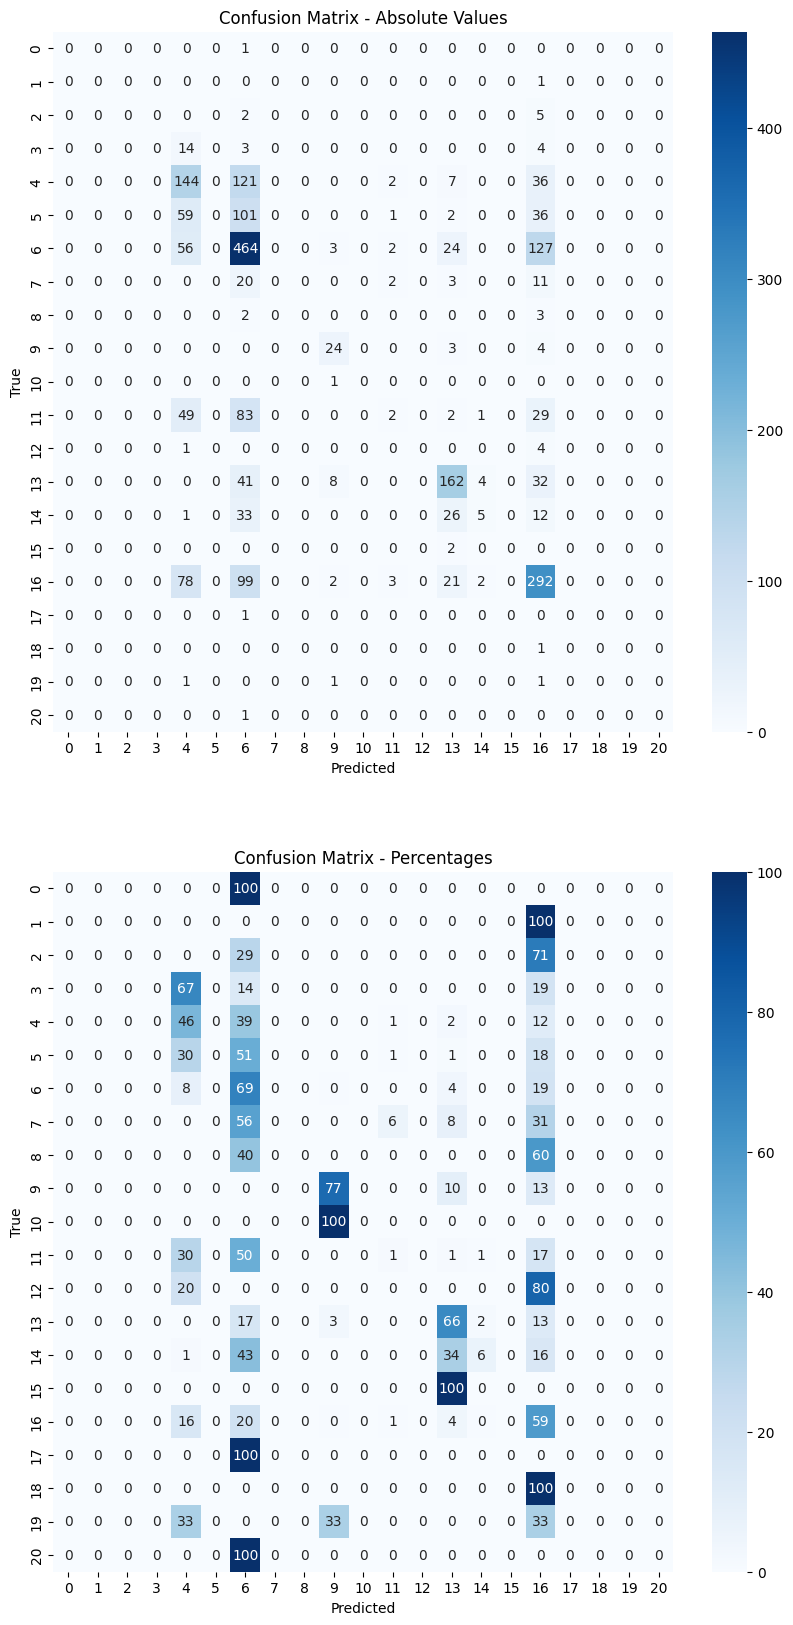

In [24]:
plot_confusion(y_true, y_pred)

In [ ]:
for i in range(100):
    print(f'Epoch {i}', end=' ')
    train_epoch()
    val_epoch()

Epoch 0 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:08<00:00,  1.89s/it]


Train Total Loss: 2.13183 Accuracy: 0.283


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:17<00:00,  2.16s/it]


Val Total Loss: 2.11622 Accuracy: 0.283
Epoch 1 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:15<00:00,  2.10s/it]


Train Total Loss: 2.10461 Accuracy: 0.284


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:15<00:00,  2.11s/it]


Val Total Loss: 2.0936 Accuracy: 0.285
Epoch 2 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:04<00:00,  1.79s/it]


Train Total Loss: 2.08524 Accuracy: 0.287


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:04<00:00,  1.79s/it]


Val Total Loss: 2.07719 Accuracy: 0.291
Epoch 3 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:18<00:00,  2.19s/it]


Train Total Loss: 2.07046 Accuracy: 0.288


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:16<00:00,  2.13s/it]


Val Total Loss: 2.06461 Accuracy: 0.291
Epoch 4 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:07<00:00,  1.87s/it]


Train Total Loss: 2.05914 Accuracy: 0.291


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:07<00:00,  1.86s/it]


Val Total Loss: 2.05341 Accuracy: 0.292
Epoch 5 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:14<00:00,  2.06s/it]


Train Total Loss: 2.04938 Accuracy: 0.293


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:11<00:00,  1.99s/it]


Val Total Loss: 2.0451 Accuracy: 0.292
Epoch 6 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:06<00:00,  1.85s/it]


Train Total Loss: 2.04203 Accuracy: 0.293


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:00<00:00,  1.68s/it]


Val Total Loss: 2.03853 Accuracy: 0.293
Epoch 7 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:03<00:00,  1.77s/it]


Train Total Loss: 2.03546 Accuracy: 0.294


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:08<00:00,  1.90s/it]


Val Total Loss: 2.03221 Accuracy: 0.296
Epoch 8 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:14<00:00,  2.06s/it]


Train Total Loss: 2.02888 Accuracy: 0.296


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:08<00:00,  1.90s/it]


Val Total Loss: 2.02542 Accuracy: 0.296
Epoch 9 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:06<00:00,  1.84s/it]


Train Total Loss: 2.02257 Accuracy: 0.297


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:14<00:00,  2.06s/it]


Val Total Loss: 2.01878 Accuracy: 0.297
Epoch 10 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:10<00:00,  1.95s/it]


Train Total Loss: 2.0144 Accuracy: 0.298


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:04<00:00,  1.80s/it]


Val Total Loss: 2.00788 Accuracy: 0.302
Epoch 11 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:05<00:00,  1.81s/it]


Train Total Loss: 1.99997 Accuracy: 0.313


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:07<00:00,  1.88s/it]


Val Total Loss: 1.99212 Accuracy: 0.326
Epoch 12 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:05<00:00,  1.81s/it]


Train Total Loss: 1.98441 Accuracy: 0.322


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:06<00:00,  1.85s/it]


Val Total Loss: 1.97659 Accuracy: 0.317
Epoch 13 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.74s/it]


Train Total Loss: 1.97163 Accuracy: 0.321


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:11<00:00,  1.99s/it]


Val Total Loss: 1.96531 Accuracy: 0.324
Epoch 14 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:07<00:00,  1.87s/it]


Train Total Loss: 1.96118 Accuracy: 0.327


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:05<00:00,  1.82s/it]


Val Total Loss: 1.95635 Accuracy: 0.329
Epoch 15 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:06<00:00,  1.84s/it]


Train Total Loss: 1.95207 Accuracy: 0.33


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.75s/it]


Val Total Loss: 1.94797 Accuracy: 0.332
Epoch 16 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:04<00:00,  1.80s/it]


Train Total Loss: 1.94384 Accuracy: 0.338


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:16<00:00,  2.12s/it]


Val Total Loss: 1.93979 Accuracy: 0.34
Epoch 17 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:06<00:00,  1.84s/it]


Train Total Loss: 1.93652 Accuracy: 0.341


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:00<00:00,  1.67s/it]


Val Total Loss: 1.93275 Accuracy: 0.34
Epoch 18 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:06<00:00,  1.84s/it]


Train Total Loss: 1.93055 Accuracy: 0.342


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:05<00:00,  1.82s/it]


Val Total Loss: 1.92614 Accuracy: 0.341
Epoch 19 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:16<00:00,  2.11s/it]


Train Total Loss: 1.92376 Accuracy: 0.342


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.74s/it]


Val Total Loss: 1.92 Accuracy: 0.345
Epoch 20 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.73s/it]


Train Total Loss: 1.91853 Accuracy: 0.342


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.72s/it]


Val Total Loss: 1.91402 Accuracy: 0.344
Epoch 21 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:06<00:00,  1.84s/it]


Train Total Loss: 1.9135 Accuracy: 0.344


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:08<00:00,  1.91s/it]


Val Total Loss: 1.90968 Accuracy: 0.342
Epoch 22 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.73s/it]


Train Total Loss: 1.90767 Accuracy: 0.343


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.73s/it]


Val Total Loss: 1.90581 Accuracy: 0.345
Epoch 23 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.75s/it]


Train Total Loss: 1.90417 Accuracy: 0.343


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:05<00:00,  1.81s/it]


Val Total Loss: 1.90206 Accuracy: 0.342
Epoch 24 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:04<00:00,  1.81s/it]


Train Total Loss: 1.90039 Accuracy: 0.344


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:03<00:00,  1.77s/it]


Val Total Loss: 1.89794 Accuracy: 0.345
Epoch 25 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:21<00:00,  2.27s/it]


Train Total Loss: 1.89812 Accuracy: 0.345


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.73s/it]


Val Total Loss: 1.89541 Accuracy: 0.345
Epoch 26 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:09<00:00,  1.92s/it]


Train Total Loss: 1.89509 Accuracy: 0.346


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:10<00:00,  1.96s/it]


Val Total Loss: 1.8928 Accuracy: 0.345
Epoch 27 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:10<00:00,  1.95s/it]


Train Total Loss: 1.89219 Accuracy: 0.345


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:09<00:00,  1.93s/it]


Val Total Loss: 1.89089 Accuracy: 0.351
Epoch 28 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.73s/it]


Train Total Loss: 1.89004 Accuracy: 0.35


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:04<00:00,  1.80s/it]


Val Total Loss: 1.88769 Accuracy: 0.358
Epoch 29 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:04<00:00,  1.79s/it]


Train Total Loss: 1.88853 Accuracy: 0.353


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:06<00:00,  1.84s/it]


Val Total Loss: 1.88593 Accuracy: 0.356
Epoch 30 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:06<00:00,  1.86s/it]


Train Total Loss: 1.88605 Accuracy: 0.352


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:07<00:00,  1.88s/it]


Val Total Loss: 1.8863 Accuracy: 0.363
Epoch 31 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.74s/it]


Train Total Loss: 1.88532 Accuracy: 0.35


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:06<00:00,  1.84s/it]


Val Total Loss: 1.88516 Accuracy: 0.356
Epoch 32 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.73s/it]


Train Total Loss: 1.88195 Accuracy: 0.353


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:03<00:00,  1.76s/it]


Val Total Loss: 1.88448 Accuracy: 0.345
Epoch 33 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:03<00:00,  1.75s/it]


Train Total Loss: 1.88162 Accuracy: 0.351


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:01<00:00,  1.71s/it]


Val Total Loss: 1.88228 Accuracy: 0.349
Epoch 34 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:14<00:00,  2.07s/it]


Train Total Loss: 1.8794 Accuracy: 0.353


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:08<00:00,  1.91s/it]


Val Total Loss: 1.87727 Accuracy: 0.361
Epoch 35 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:01<00:00,  1.71s/it]


Train Total Loss: 1.87771 Accuracy: 0.354


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:06<00:00,  1.84s/it]


Val Total Loss: 1.87516 Accuracy: 0.362
Epoch 36 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:06<00:00,  1.84s/it]


Train Total Loss: 1.87623 Accuracy: 0.356


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:09<00:00,  1.94s/it]


Val Total Loss: 1.87612 Accuracy: 0.349
Epoch 37 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:12<00:00,  2.01s/it]


Train Total Loss: 1.87444 Accuracy: 0.354


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:06<00:00,  1.84s/it]


Val Total Loss: 1.87494 Accuracy: 0.349
Epoch 38 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.74s/it]


Train Total Loss: 1.87189 Accuracy: 0.357


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:01<00:00,  1.70s/it]


Val Total Loss: 1.87014 Accuracy: 0.361
Epoch 39 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:10<00:00,  1.95s/it]


Train Total Loss: 1.87111 Accuracy: 0.357


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:24<00:00,  2.35s/it]


Val Total Loss: 1.86899 Accuracy: 0.357
Epoch 40 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.73s/it]


Train Total Loss: 1.86865 Accuracy: 0.361


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:08<00:00,  1.90s/it]


Val Total Loss: 1.86773 Accuracy: 0.361
Epoch 41 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:06<00:00,  1.85s/it]


Train Total Loss: 1.86657 Accuracy: 0.361


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:09<00:00,  1.92s/it]


Val Total Loss: 1.86543 Accuracy: 0.362
Epoch 42 

100%|█████████████████████████████████████████████████████████████████| 36/36 [00:58<00:00,  1.62s/it]


Train Total Loss: 1.86551 Accuracy: 0.36


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:13<00:00,  2.05s/it]


Val Total Loss: 1.8656 Accuracy: 0.353
Epoch 43 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:10<00:00,  1.95s/it]


Train Total Loss: 1.86435 Accuracy: 0.357


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:11<00:00,  1.99s/it]


Val Total Loss: 1.86248 Accuracy: 0.36
Epoch 44 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:16<00:00,  2.13s/it]


Train Total Loss: 1.86282 Accuracy: 0.357


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:04<00:00,  1.79s/it]


Val Total Loss: 1.86079 Accuracy: 0.359
Epoch 45 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.74s/it]


Train Total Loss: 1.86197 Accuracy: 0.358


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:08<00:00,  1.90s/it]


Val Total Loss: 1.8599 Accuracy: 0.362
Epoch 46 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:04<00:00,  1.79s/it]


Train Total Loss: 1.86156 Accuracy: 0.36


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:15<00:00,  2.10s/it]


Val Total Loss: 1.86185 Accuracy: 0.347
Epoch 47 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:08<00:00,  1.89s/it]


Train Total Loss: 1.86119 Accuracy: 0.355


100%|█████████████████████████████████████████████████████████████████| 36/36 [00:58<00:00,  1.62s/it]


Val Total Loss: 1.86295 Accuracy: 0.346
Epoch 48 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:08<00:00,  1.91s/it]


Train Total Loss: 1.85772 Accuracy: 0.361


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:04<00:00,  1.80s/it]


Val Total Loss: 1.85701 Accuracy: 0.363
Epoch 49 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.73s/it]


Train Total Loss: 1.85697 Accuracy: 0.361


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:10<00:00,  1.95s/it]


Val Total Loss: 1.85553 Accuracy: 0.358
Epoch 50 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:05<00:00,  1.82s/it]


Train Total Loss: 1.85641 Accuracy: 0.359


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:05<00:00,  1.82s/it]


Val Total Loss: 1.8546 Accuracy: 0.363
Epoch 51 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:20<00:00,  2.23s/it]


Train Total Loss: 1.85452 Accuracy: 0.361


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:00<00:00,  1.67s/it]


Val Total Loss: 1.85633 Accuracy: 0.356
Epoch 52 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:10<00:00,  1.96s/it]


Train Total Loss: 1.85462 Accuracy: 0.358


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:00<00:00,  1.68s/it]


Val Total Loss: 1.85237 Accuracy: 0.359
Epoch 53 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:08<00:00,  1.89s/it]


Train Total Loss: 1.85568 Accuracy: 0.359


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:06<00:00,  1.85s/it]


Val Total Loss: 1.85084 Accuracy: 0.362
Epoch 54 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:05<00:00,  1.82s/it]


Train Total Loss: 1.85255 Accuracy: 0.361


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:12<00:00,  2.00s/it]


Val Total Loss: 1.85121 Accuracy: 0.364
Epoch 55 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:04<00:00,  1.80s/it]


Train Total Loss: 1.85096 Accuracy: 0.36


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:10<00:00,  1.96s/it]


Val Total Loss: 1.85015 Accuracy: 0.356
Epoch 56 

100%|█████████████████████████████████████████████████████████████████| 36/36 [00:59<00:00,  1.65s/it]


Train Total Loss: 1.85065 Accuracy: 0.361


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:01<00:00,  1.71s/it]


Val Total Loss: 1.85218 Accuracy: 0.36
Epoch 57 

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.73s/it]


Train Total Loss: 1.84979 Accuracy: 0.362


  0%|                                                                          | 0/36 [00:00<?, ?it/s]

In [46]:
val_epoch()

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:08<00:00,  1.89s/it]

Val Total Loss: 1.79751 Accuracy: 0.374


In [50]:
torch.save(model.state_dict(), 'weight.pth')

In [19]:
encoder(inputs_embeds=X[:, :, 1:], attention_mask=m).last_hidden_state

tensor([[[-0.9506, -1.0241, -1.0530,  ...,  0.9812,  1.0417,  0.9451],
         [ 0.7102,  0.2792, -0.0825,  ...,  0.9809,  1.0477,  0.9524],
         [ 0.8573,  0.9642,  0.7275,  ...,  0.9739,  1.0498,  0.9607],
         ...,
         [ 0.8280, -0.4950, -1.4916,  ...,  1.1379,  1.1633,  1.1398],
         [-0.4524, -1.4348, -1.7933,  ...,  1.1615,  1.1949,  1.1696],
         [-1.6544, -1.8386, -1.7175,  ...,  1.1555,  1.1971,  1.1681]],

        [[-1.0414, -0.9149, -0.8234,  ...,  1.0566,  1.0201,  1.0146],
         [ 0.6124,  0.3958,  0.1637,  ...,  1.0612,  1.0240,  1.0267],
         [ 0.7576,  1.0800,  0.9744,  ...,  1.0536,  1.0248,  1.0344],
         ...,
         [ 0.7786, -0.4324, -1.3649,  ...,  1.1770,  1.1506,  1.1753],
         [-0.4901, -1.3836, -1.6932,  ...,  1.1920,  1.1849,  1.1972],
         [-1.6989, -1.7630, -1.5743,  ...,  1.1934,  1.1788,  1.2022]],

        [[-0.9525, -1.0261, -1.0523,  ...,  0.9826,  1.0414,  0.9448],
         [ 0.7082,  0.2771, -0.0820,  ...,  0

In [249]:
def train_epoch():
    model.train()

    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0
    
    for batch in train_dataloader:
        _, times, _, values, _, mask, aux, labels = batch
        labels = labels.to(device)
        values, mask = values.to(device), mask.to(device)
    
        optimizer.zero_grad()
    
        logits = model(values, mask)
        loss = criterion(logits, labels)
        total_loss.append(loss.item())
    
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)
        correct_predictions = (predicted_labels == labels).sum().item()
    
        total_correct_predictions += correct_predictions
        total_predictions += labels.size(0)
    
        loss.backward()
        optimizer.step()

    print(f'Total Loss: {round(sum(total_loss) / len(total_loss), 5)} Accuracy: {round(total_correct_predictions / total_predictions, 3)}', end=' ')

In [250]:
def val_epoch():
    model.eval()

    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            _, times, _, values, _, mask, aux, labels = batch
            labels = labels.to(device)
            values, mask = values.to(device), mask.to(device)

            logits = model(values, mask)
            loss = criterion(logits, labels)
            total_loss.append(loss.item())

            probabilities = torch.nn.functional.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probabilities, dim=1)
            correct_predictions = (predicted_labels == labels).sum().item()

            total_correct_predictions += correct_predictions
            total_predictions += labels.size(0)

    print(f'Total Loss: {round(sum(total_loss) / len(total_loss), 5)} Accuracy: {round(total_correct_predictions / total_predictions, 3)}')

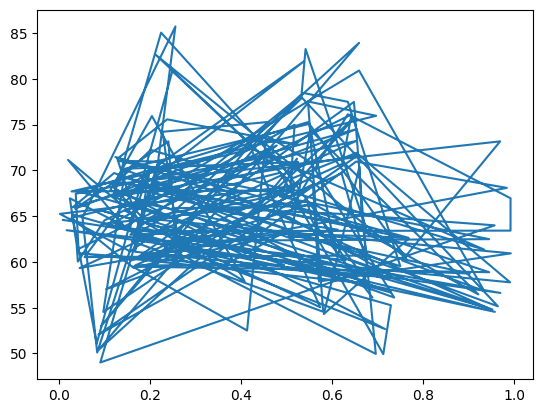

In [239]:
plt.plot(X[0, :, 0], X[0, :, 1])

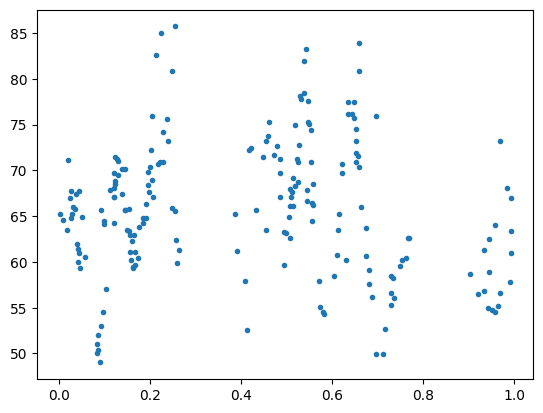

In [240]:
plt.plot(X[0, :, 0], X[0, :, 1], '.')

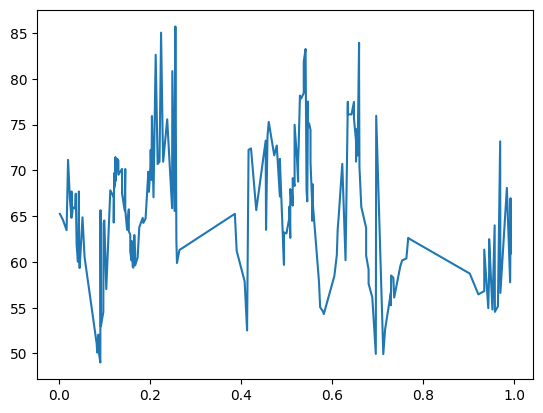

In [242]:
plt.plot(sorted_X[0, :, 0], sorted_X[0, :, 1])

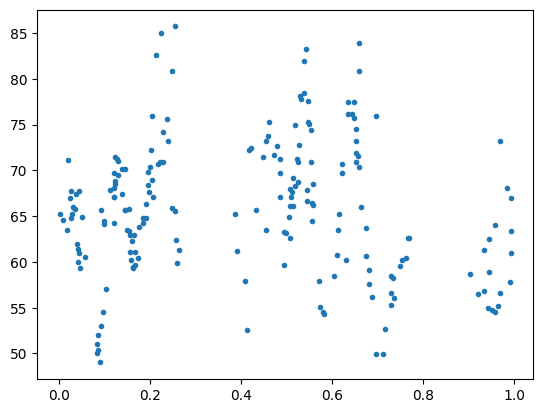

In [243]:
plt.plot(sorted_X[0, :, 0], sorted_X[0, :, 1], '.')

In [144]:
(sorted_X[0, :, 0] * ~sorted_mask[0]).sum()

tensor(90.4022)

In [145]:
sorted_X[0, :, 0].sum()

tensor(90.4022)

In [152]:
m

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]], dtype=torch.int32)

In [182]:
classes.shape

torch.Size([128])

Using cuda


In [69]:
model = TimeSeriesTransformerModel(config)
model = embedder.to(device)

In [79]:
encoder = TimeSeriesTransformerEncoder(config)
# encoder = encoder.to(device)

In [56]:
lcs.shape

torch.Size([128, 1, 3, 570])

In [60]:
lcs = lcs.transpose(1, -1)
lcs.shape

torch.Size([128, 570, 3, 1])

In [74]:
enc_input = lcs[:, :, 1:, 0]
# enc_input = enc_input.to(device)
enc_input.shape

torch.Size([128, 570, 2])

In [90]:
lcs_mask = lcs_mask.transpose(1, -1)
lcs_mask.shape

torch.Size([128, 570, 3, 1])

In [93]:
(lcs_mask[:, :, 1, 0] != lcs_mask[:, :, 2, 0]).sum()

tensor(0)

In [94]:
attention_mask = lcs_mask[:, :, 1, 0]
attention_mask.shape

torch.Size([128, 570])

In [95]:
# inputs_embeds `torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size) 128 570 2
encoder_outputs = encoder(
    inputs_embeds=enc_input,
    attention_mask=attention_mask,
    head_mask=None,
    output_attentions=None,
    output_hidden_states=None,
    return_dict=None,
)

In [104]:
past_time_features = lcs[:, :, 0, 0:]
past_time_features.shape

torch.Size([128, 570, 1])

In [96]:
encoder_outputs.last_hidden_state.shape

torch.Size([128, 570, 64])

In [29]:
model = ClassificationModel(pretrained_model=embedder, device=device)
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=10, verbose=True)
criterion = nn.CrossEntropyLoss()

In [35]:
values = lcs[:, 0, 1, :]
time_features = lcs[:, 0, 0, :]
observed_mask = masks[0][:, 0, 0, :]

In [37]:
values.shape, time_features.shape, observed_mask.shape

(torch.Size([128, 570]), torch.Size([128, 570]), torch.Size([128, 570]))

In [ ]:
outputs = self.pretrained_model(
    past_time_features=past_times.to(self.device),
    past_values=past_values.to(self.device),
    future_time_features=future_times.to(self.device),
    past_observed_mask=past_mask.to(self.device),
    static_real_features=static_real_features
)

# embedding = torch.mean(outputs.encoder_last_hidden_state, dim=1)
embedding = outputs.encoder_last_hidden_state[:, 0, :]
logits = self.classifier(embedding)